In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  # natural language processing
nltk.download("stopwords")
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer   #####

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Load Tweet dataset
df0 = pd.read_csv('/content/twcs.csv')
df0

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
...,...,...,...,...,...,...,...
973323,1079847,Morrisons,False,Mon Oct 23 19:45:05 +0000 2017,"@374721 Hi there, Hmm how strange! Can you ple...","1079848,1079849",1079850.0
973324,1079848,374721,True,Wed Nov 01 21:44:24 +0000 2017,@Morrisons Sorry the packaging has been recycled,NaN,1079847.0
973325,1079849,374722,True,Mon Oct 23 20:03:28 +0000 2017,@Morrisons its in his pic,"1079851,1079852,1079853,1079854",1079847.0
973326,1079851,374723,True,Mon Oct 23 21:49:55 +0000 2017,@374722 @Morrisons About a third of it is miss...,NaN,1079849.0


In [ ]:
df=df0[['text']][0:10000]
df

,text
0,@115712 I understand. I would like to assist y...
1,@sprintcare and how do you propose we do that
2,@sprintcare I have sent several private messag...
3,@115712 Please send us a Private Message so th...
4,@sprintcare I did.
...,...
9995,@MicrosoftHelps That link just gives me gibber...
9996,"@118890 In that case, kindly contact our Answe..."
9997,@MicrosoftHelps Has any other Windows 10 user ...
9998,@118890 1/2 Your Internet Service Provider can...


In [ ]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''

    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [ ]:
cleantext=[]
for item in tqdm(df['text']):
    words=tweet_to_words(str(item))
    cleantext+=[words]
df['cleantext']=cleantext
df

100%|██████████| 10000/10000 [00:22<00:00, 450.67it/s]


,text,cleantext
0,@115712 I understand. I would like to assist y...,"[115712, understand, would, like, assist, woul..."
1,@sprintcare and how do you propose we do that,"[sprintcar, propos]"
2,@sprintcare I have sent several private messag...,"[sprintcar, sent, sever, privat, messag, one, ..."
3,@115712 Please send us a Private Message so th...,"[115712, pleas, send, us, privat, messag, assi..."
4,@sprintcare I did.,[sprintcar]
...,...,...
9995,@MicrosoftHelps That link just gives me gibber...,"[microsofthelp, link, give, gibberish, 2a0, tq..."
9996,"@118890 In that case, kindly contact our Answe...","[118890, case, kindli, contact, answer, desk, ..."
9997,@MicrosoftHelps Has any other Windows 10 user ...,"[microsofthelp, window, 10, user, notic, massi..."
9998,@118890 1/2 Your Internet Service Provider can...,"[118890, 1, 2, internet, servic, provid, check..."


In [ ]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [ ]:
unlist(['a','b','c'])

'a b c '

In [ ]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: unlist(x))
    return df

In [ ]:
df2 = compute_vader_scores(df,'cleantext')
df2

,text,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2
0,@115712 I understand. I would like to assist y...,"[115712, understand, would, like, assist, woul...",0.000,0.815,0.185,0.3612,115712 understand would like assist would need...
1,@sprintcare and how do you propose we do that,"[sprintcar, propos]",0.000,1.000,0.000,0.0000,sprintcar propos
2,@sprintcare I have sent several private messag...,"[sprintcar, sent, sever, privat, messag, one, ...",0.000,1.000,0.000,0.0000,sprintcar sent sever privat messag one respond...
3,@115712 Please send us a Private Message so th...,"[115712, pleas, send, us, privat, messag, assi...",0.000,0.847,0.153,0.2023,115712 pleas send us privat messag assist clic...
4,@sprintcare I did.,[sprintcar],0.000,1.000,0.000,0.0000,sprintcar
...,...,...,...,...,...,...,...
9995,@MicrosoftHelps That link just gives me gibber...,"[microsofthelp, link, give, gibberish, 2a0, tq...",0.000,0.833,0.167,0.4939,microsofthelp link give gibberish 2a0 tqo0 amp...
9996,"@118890 In that case, kindly contact our Answe...","[118890, case, kindli, contact, answer, desk, ...",0.000,0.710,0.290,0.5423,118890 case kindli contact answer desk support...
9997,@MicrosoftHelps Has any other Windows 10 user ...,"[microsofthelp, window, 10, user, notic, massi...",0.000,1.000,0.000,0.0000,microsofthelp window 10 user notic massiv data...
9998,@118890 1/2 Your Internet Service Provider can...,"[118890, 1, 2, internet, servic, provid, check...",0.000,1.000,0.000,0.0000,118890 1 2 internet servic provid check anoth ...


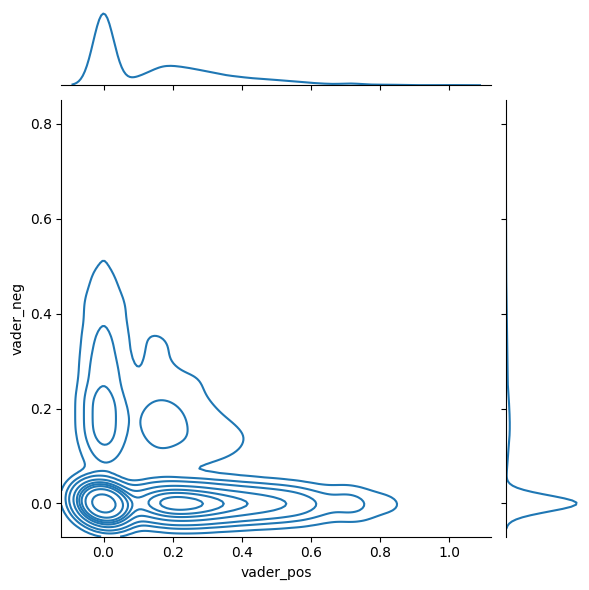

In [ ]:
sns.jointplot(data=df2, x='vader_pos', y='vader_neg', kind="kde")

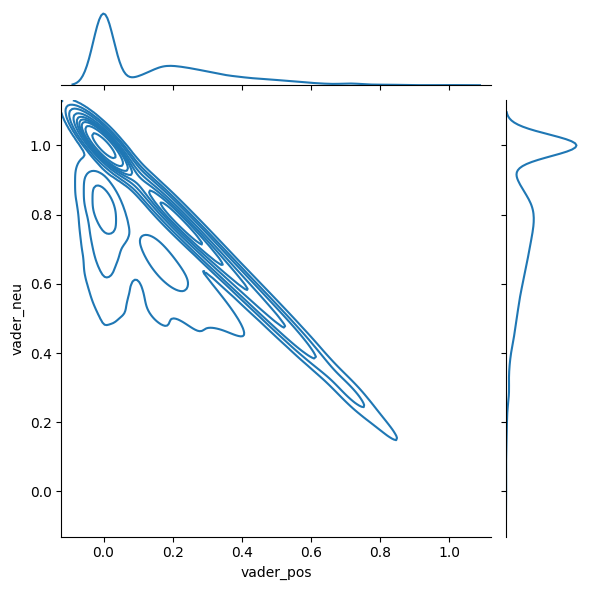

In [ ]:
sns.jointplot(data=df2, x='vader_pos', y='vader_neu', kind="kde")

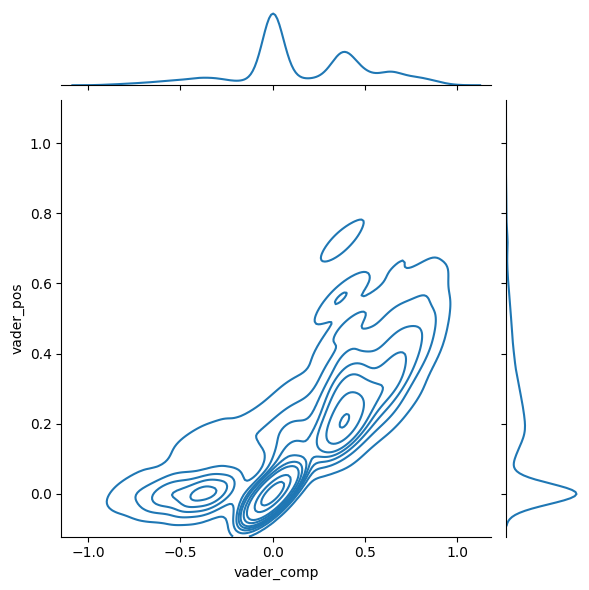

In [ ]:
sns.jointplot(data=df2, x='vader_comp', y='vader_pos', kind="kde")

In [ ]:
class0=[]
for i in range(len(df2)):
    if df2.loc[i,'vader_comp']<0.0:
        class0+=[0]
    elif df2.loc[i,'vader_comp']==0.0:
        class0+=[1]
    else:
        class0+=[2]

df2['class']=class0
df2['class'].value_counts()

# vader_classes = ['Vader_Negative','Vader_Neutral','Vader_Positive']

,count
class,
2,4836
1,3636
0,1528


In [ ]:
df2

,text,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2,class
0,@115712 I understand. I would like to assist y...,"[115712, understand, would, like, assist, woul...",0.000,0.815,0.185,0.3612,115712 understand would like assist would need...,2
1,@sprintcare and how do you propose we do that,"[sprintcar, propos]",0.000,1.000,0.000,0.0000,sprintcar propos,1
2,@sprintcare I have sent several private messag...,"[sprintcar, sent, sever, privat, messag, one, ...",0.000,1.000,0.000,0.0000,sprintcar sent sever privat messag one respond...,1
3,@115712 Please send us a Private Message so th...,"[115712, pleas, send, us, privat, messag, assi...",0.000,0.847,0.153,0.2023,115712 pleas send us privat messag assist clic...,2
4,@sprintcare I did.,[sprintcar],0.000,1.000,0.000,0.0000,sprintcar,1
...,...,...,...,...,...,...,...,...
9995,@MicrosoftHelps That link just gives me gibber...,"[microsofthelp, link, give, gibberish, 2a0, tq...",0.000,0.833,0.167,0.4939,microsofthelp link give gibberish 2a0 tqo0 amp...,2
9996,"@118890 In that case, kindly contact our Answe...","[118890, case, kindli, contact, answer, desk, ...",0.000,0.710,0.290,0.5423,118890 case kindli contact answer desk support...,2
9997,@MicrosoftHelps Has any other Windows 10 user ...,"[microsofthelp, window, 10, user, notic, massi...",0.000,1.000,0.000,0.0000,microsofthelp window 10 user notic massiv data...,1
9998,@118890 1/2 Your Internet Service Provider can...,"[118890, 1, 2, internet, servic, provid, check...",0.000,1.000,0.000,0.0000,118890 1 2 internet servic provid check anoth ...,1


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer



In [ ]:
print('Before Tokenization & Padding \n', df2['cleantext2'][0])
X, tokenizer = tokenize_pad_sequences(df2['cleantext2'])
print('After Tokenization & Padding \n', X[0])
print(X.shape)

Before Tokenization & Padding 
 115712 understand would like assist would need get privat secur link assist 
After Tokenization & Padding 
 [1549  252   48   17   31   48   26    8  693  499   69   31    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
(10000, 50)


In [ ]:
y = pd.get_dummies(df2['class'])  ### Y_TRUE
print(y)

          0      1      2
0     False  False   True
1     False   True  False
2     False   True  False
3     False  False   True
4     False   True  False
...     ...    ...    ...
9995  False  False   True
9996  False  False   True
9997  False   True  False
9998  False   True  False
9999   True  False  False

[10000 rows x 3 columns]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (6000, 50) (6000, 3)
Validation Set:  (2000, 50) (2000, 3)
Test Set:  (2000, 50) (2000, 3)


In [ ]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

In [ ]:
vocab_size = 5000
embedding_size = 32
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

In [ ]:
# sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


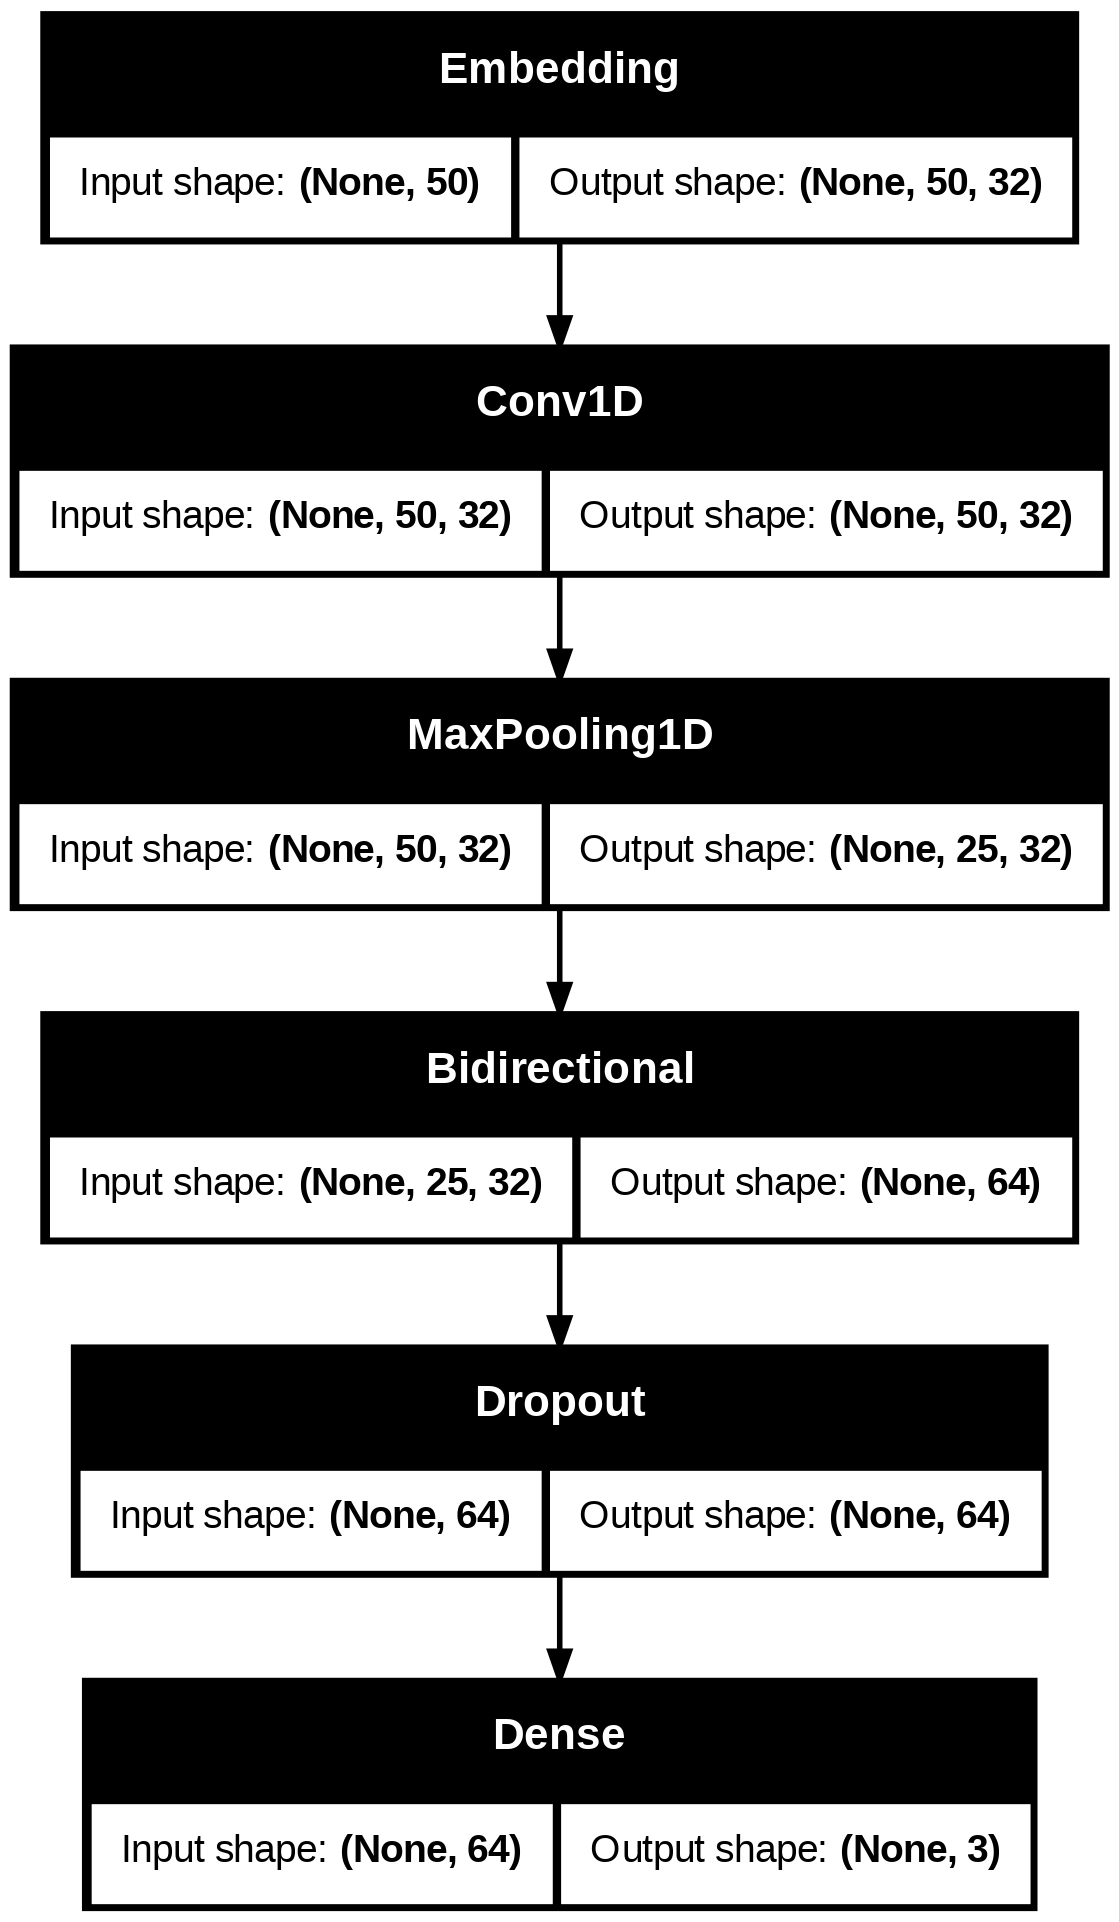

In [ ]:
import tensorflow as tf
# tf.keras.utils.plot_model(model, show_shapes=True)
# Option 2: Explicitly call build() with the input shape
model.build(input_shape=(None, max_len)) # Replace None with batch size if known

# Now plot the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=64,epochs=epochs,verbose=1)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5045 - loss: 0.9852 - precision_3: 0.5266 - recall_3: 0.2750 - val_accuracy: 0.5765 - val_loss: 0.9231 - val_precision_3: 0.6766 - val_recall_3: 0.4090
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6379 - loss: 0.8392 - precision_3: 0.7201 - recall_3: 0.4892 - val_accuracy: 0.7385 - val_loss: 0.6353 - val_precision_3: 0.8129 - val_recall_3: 0.6670
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8116 - loss: 0.5154 - precision_3: 0.8513 - recall_3: 0.7707 - val_accuracy: 0.8240 - val_loss: 0.4782 - val_precision_3: 0.8425 - val_recall_3: 0.7970
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8608 - loss: 0.3953 - precision_3: 0.8807 - recall_3: 0.8378 - val_accuracy: 0.8575 - val_loss: 0.4243 - val_precision_3: 0.8638 - val_recall_3: 0.8435
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8916 - loss: 0.3202 - precision_3: 0.9010 - recall_3: 0.8792 - val

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [ ]:
X_test

array([[ 114,  138,  198, ...,    0,    0,    0],
       [2022,    2,    1, ...,    0,    0,    0],
       [1790,  273,  277, ...,    0,    0,    0],
       ...,
       [ 517,  156,   38, ...,    0,    0,    0],
       [  52, 2162,    6, ...,    0,    0,    0],
       [ 172, 1215,   19, ...,    0,    0,    0]], dtype=int32)

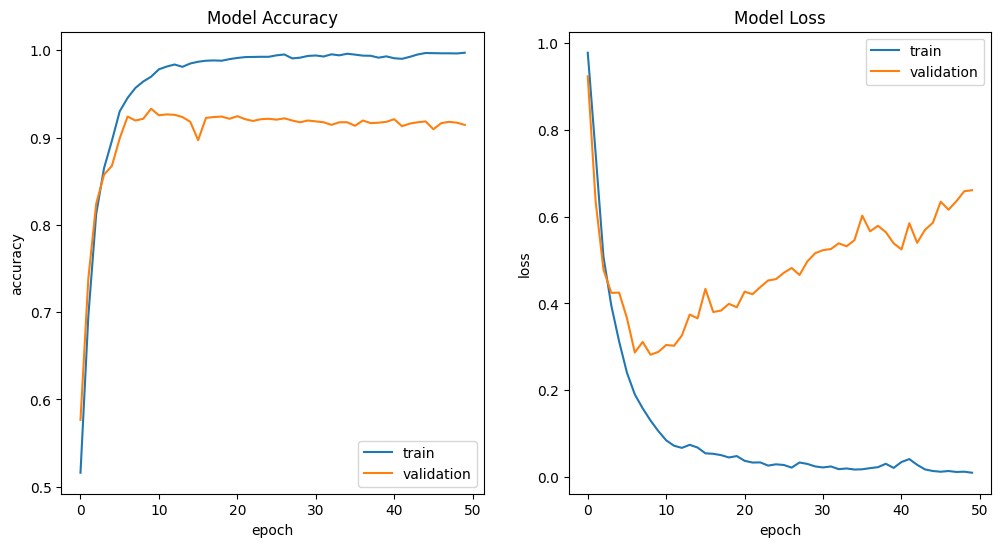

In [ ]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
2    964
1    731
0    305
Name: count, dtype: int64
2    957
1    751
0    292
Name: count, dtype: int64


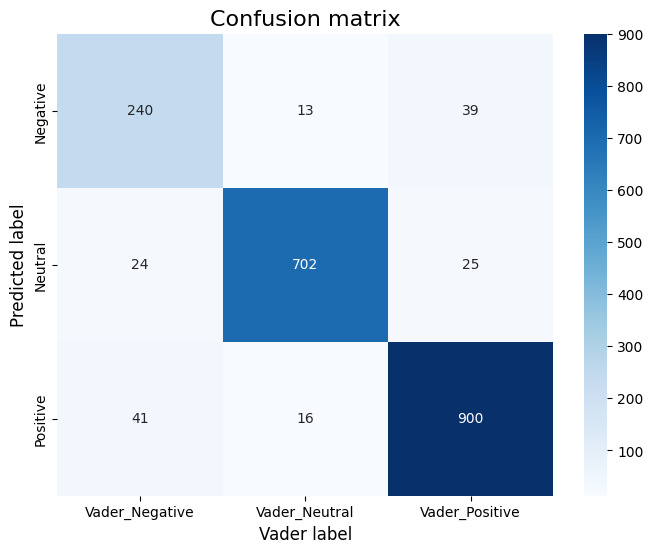

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes =   ['Negative','Neutral', 'Positive']
    vader_classes =   ['Vader_Negative','Vader_Neutral', 'Vader_Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))

    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())

    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=vader_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Vader label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

In [ ]:
vader_classes= ['Vader_Negative','Vader_Neutral', 'Vader_Positive']
y_pred = model.predict(X_test)
Y_PRED=np.argmax(y_pred,axis=1)
print(Y_PRED)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[2 2 2 ... 2 2 1]


In [ ]:
print(y_test)
Y_TRUE=np.argmax(np.array(y_test),axis=1)
print(Y_TRUE)

          0      1      2
9953  False  False   True
3850  False  False   True
4962  False   True  False
3886  False   True  False
5437  False  False   True
...     ...    ...    ...
3919  False   True  False
162   False  False   True
7903  False  False   True
2242  False  False   True
2745  False   True  False

[2000 rows x 3 columns]
[2 2 1 ... 2 2 1]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_TRUE, Y_PRED, target_names=vader_classes, digits=4))

                precision    recall  f1-score   support

Vader_Negative     0.8219    0.7869    0.8040       305
 Vader_Neutral     0.9348    0.9603    0.9474       731
Vader_Positive     0.9404    0.9336    0.9370       964

      accuracy                         0.9210      2000
     macro avg     0.8990    0.8936    0.8961      2000
  weighted avg     0.9203    0.9210    0.9205      2000



In [ ]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))

Accuracy  : 0.9210
Precision : 0.9218
Recall    : 0.9200
F1 Score  : 0.9209
